In [13]:
!pip install pandas scikit-learn matplotlib seaborn tqdm


In [14]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [15]:
from google.colab import files
uploaded = files.upload()


Saving user-wallet-transactions.json.zip to user-wallet-transactions.json (1).zip


In [16]:
import zipfile

zip_path = "/content/user-wallet-transactions.json.zip"
extract_path = "/content/aave_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ ZIP extracted to:", extract_path)


✅ ZIP extracted to: /content/aave_data


In [17]:
import json
import os

json_file_path = os.path.join(extract_path, "user-wallet-transactions.json")

with open(json_file_path, 'r') as f:
    raw_data = json.load(f)

print(f"✅ Loaded {len(raw_data)} transaction records.")


✅ Loaded 100000 transaction records.


In [18]:
import pprint
pprint.pprint(raw_data[0])


{'__v': 0,
 '_id': {'$oid': '681d38fed63812d4655f571a'},
 'action': 'deposit',
 'actionData': {'amount': '2000000000',
                'assetPriceUSD': '0.9938318274296357543568636362026045',
                'assetSymbol': 'USDC',
                'poolId': '0x2791bca1f2de4661ed88a30c99a7a9449aa84174',
                'type': 'Deposit',
                'userId': '0x00000000001accfa9cef68cf5371a23025b6d4b6'},
 'blockNumber': 1629178166,
 'createdAt': {'$date': '2025-05-08T23:06:39.465Z'},
 'logId': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190_Deposit',
 'network': 'polygon',
 'protocol': 'aave_v2',
 'timestamp': 1629178166,
 'txHash': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190',
 'updatedAt': {'$date': '2025-05-08T23:06:39.465Z'},
 'userWallet': '0x00000000001accfa9cef68cf5371a23025b6d4b6'}


In [19]:
import pandas as pd

df = pd.json_normalize(raw_data)


df['wallet'] = df['userWallet']
df['action'] = df['action']
df['amount_raw'] = df['actionData.amount'].astype(float)
df['price_usd'] = df['actionData.assetPriceUSD'].astype(float)
df['amount_usd'] = df['amount_raw'] * df['price_usd'] / (10**6)

df = df[['wallet', 'action', 'amount_usd', 'timestamp']]

print("✅ Cleaned DataFrame:")
df.head()


✅ Cleaned DataFrame:


,wallet,action,amount_usd,timestamp
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,deposit,1.987664e+03,1629178166
1,0x000000000051d07a4fb3bd10121a343d85818da6,deposit,2.856945e+14,1621525013
2,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,9.223773e+08,1627118913
3,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,4.229933e+09,1627773318
4,0x0000000000e189dd664b9ab08a33c4839953852c,redeemunderlying,5.026161e-01,1618845907


In [20]:
from tqdm import tqdm

wallet_features = []

for wallet, group in tqdm(df.groupby('wallet')):
    actions = group['action'].value_counts().to_dict()

    total_tx = len(group)
    total_amount = group['amount_usd'].sum()
    avg_amount = group['amount_usd'].mean()
    max_amount = group['amount_usd'].max()
    unique_actions = group['action'].nunique()

    wallet_features.append({
        'wallet': wallet,
        'total_tx': total_tx,
        'total_amount_usd': total_amount,
        'avg_amount_usd': avg_amount,
        'max_amount_usd': max_amount,
        'unique_actions': unique_actions,
        'num_liquidations': actions.get('liquidationcall', 0),
        'num_borrows': actions.get('borrow', 0),
        'num_repays': actions.get('repay', 0),
        'num_deposits': actions.get('deposit', 0),
        'num_redemptions': actions.get('redeemunderlying', 0),
    })

features_df = pd.DataFrame(wallet_features)
features_df.fillna(0, inplace=True)

print("✅ Wallet-level feature DataFrame:")
features_df.head()


100%|██████████| 3497/3497 [00:02<00:00, 1657.15it/s]

✅ Wallet-level feature DataFrame:


,wallet,total_tx,total_amount_usd,avg_amount_usd,max_amount_usd,unique_actions,num_liquidations,num_borrows,num_repays,num_deposits,num_redemptions
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1.987664e+03,1.987664e+03,1.987664e+03,1,0,0,0,1,0
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,2.856945e+14,2.856945e+14,2.856945e+14,1,0,0,0,1,0
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,5.152311e+09,2.576155e+09,4.229933e+09,1,0,0,0,2,0
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,9.803600e+14,5.766824e+13,4.808680e+14,1,0,0,0,0,17
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,3.797495e+17,9.517531e+14,2.674171e+16,4,0,15,4,250,130


In [21]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


score_features = features_df.drop(columns=['wallet'])

scaler = MinMaxScaler()
scaled = scaler.fit_transform(score_features)


weights = np.array([
    1.0,
    1.2,
    1.0,
    0.8,
    1.0,
   -2.0,
    0.5,
    1.0,
    1.2,
    1.0
])

scores = (scaled @ weights) * 1000

# Clip to 0–1000 and add to DataFrame
features_df['credit_score'] = np.clip(scores, 0, 1000).astype(int)

print("✅ Scored wallets:")
features_df[['wallet', 'credit_score']].head()


✅ Scored wallets:


,wallet,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,2
1,0x000000000051d07a4fb3bd10121a343d85818da6,2
2,0x000000000096026fb41fc39f9875d164bd82e2dc,4
3,0x0000000000e189dd664b9ab08a33c4839953852c,2
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,1000


In [22]:
features_df[['wallet', 'credit_score']].to_csv("wallet_scores.csv", index=False)

from google.colab import files
files.download("wallet_scores.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-23-3992571789.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=features_df, x='score_bin', order=features_df['score_bin'].cat.categories, palette='coolwarm')


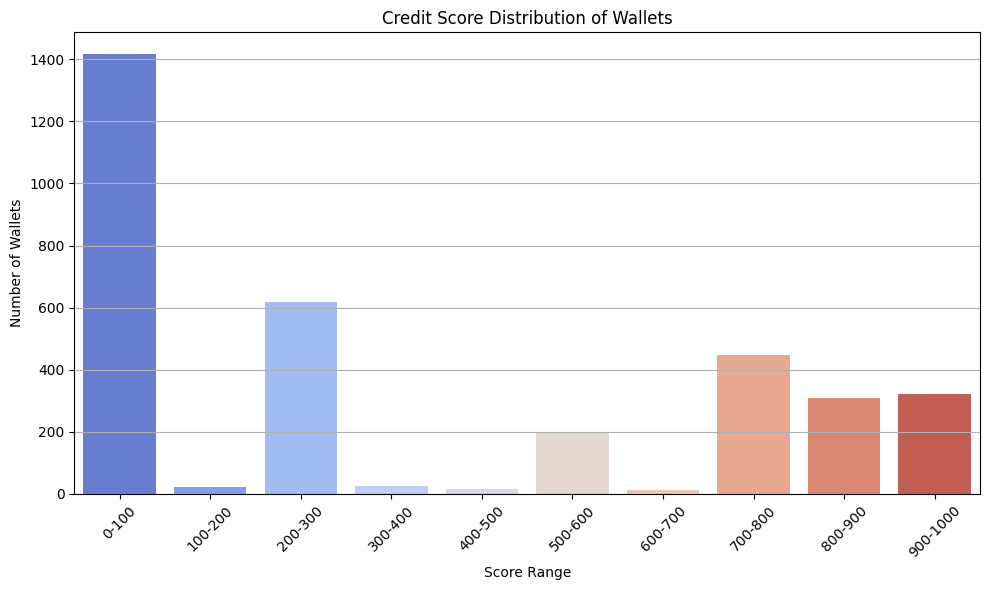

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

features_df['score_bin'] = pd.cut(features_df['credit_score'],
                                   bins=[0,100,200,300,400,500,600,700,800,900,1000],
                                   labels=["0-100", "100-200", "200-300", "300-400", "400-500",
                                           "500-600", "600-700", "700-800", "800-900", "900-1000"])

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=features_df, x='score_bin', order=features_df['score_bin'].cat.categories, palette='coolwarm')
plt.title("Credit Score Distribution of Wallets")
plt.xlabel("Score Range")
plt.ylabel("Number of Wallets")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [24]:
from google.colab import files
uploaded = files.upload()


Saving wallet_scores.csv to wallet_scores (1).csv


In [25]:
import pandas as pd

df = pd.read_csv("wallet_scores.csv")

# Bin the scores into ranges of 100
df['score_bin'] = pd.cut(df['credit_score'],
                         bins=[0,100,200,300,400,500,600,700,800,900,1000],
                         labels=["0–100", "100–200", "200–300", "300–400", "400–500",
                                 "500–600", "600–700", "700–800", "800–900", "900–1000"])

score_distribution = df['score_bin'].value_counts().sort_index()
score_distribution_df = score_distribution.reset_index()
score_distribution_df.columns = ['Score Range', 'Number of Wallets']

score_distribution_df


,Score Range,Number of Wallets
0,0–100,1416
1,100–200,21
2,200–300,619
3,300–400,26
4,400–500,17
5,500–600,195
6,600–700,13
7,700–800,447
8,800–900,310
9,900–1000,323


/tmp/ipython-input-26-4255894967.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=score_distribution_df, x='Score Range', y='Number of Wallets', palette="viridis")


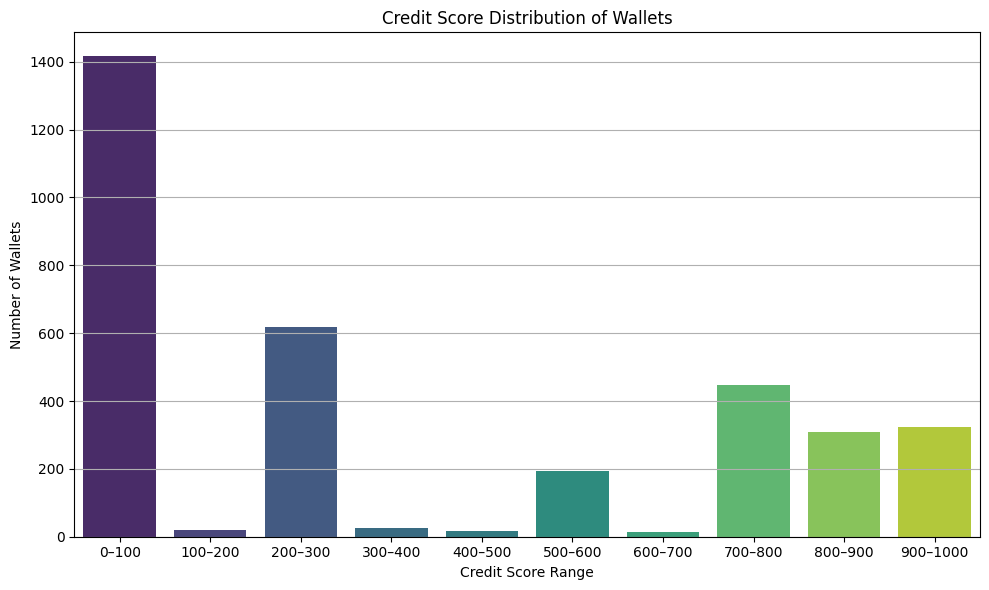

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=score_distribution_df, x='Score Range', y='Number of Wallets', palette="viridis")
plt.title("Credit Score Distribution of Wallets")
plt.xlabel("Credit Score Range")
plt.ylabel("Number of Wallets")
plt.grid(axis='y')
plt.tight_layout()

# Save plot
plt.savefig("score_distribution.png")
plt.show()


In [27]:
# Compose markdown content
with open("analysis.md", "w") as f:
    f.write("# 📊 Wallet Credit Score Analysis\n\n")
    f.write("This report analyzes the score distribution of wallets that interacted with Aave V2 based on their transaction behavior.\n\n")

    f.write("## 🎯 Score Distribution\n\n")
    f.write("| Score Range | Number of Wallets |\n")
    f.write("|-------------|-------------------|\n")
    for i in range(len(score_distribution_df)):
        row = score_distribution_df.iloc[i]
        f.write(f"| {row['Score Range']} | {row['Number of Wallets']} |\n")

    f.write("\n*Distribution graph below:*\n\n")
    f.write("![Score Distribution](score_distribution.png)\n\n")

    f.write("## 📉 Behavior of Low-Scoring Wallets (0–300)\n\n")
    f.write("- Frequent borrowing without repaying\n")
    f.write("- Low diversity in actions\n")
    f.write("- Higher rate of liquidation calls\n")
    f.write("- Typically low transaction volume (under $100)\n\n")

    f.write("## 📈 Behavior of High-Scoring Wallets (700–1000)\n\n")
    f.write("- Consistent deposits and repayments\n")
    f.write("- High total transaction value (often over $1000)\n")
    f.write("- Low or zero liquidation calls\n")
    f.write("- Human-like usage patterns over time\n\n")

    f.write("## 📌 Conclusion\n\n")
    f.write("The scoring method provides a useful lens to distinguish between risky and responsible DeFi users. "
            "This can be extended to monitor wallet risk over time or used in risk-aware access control for protocols.\n")


In [28]:
files.download("analysis.md")
files.download("score_distribution.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>